# Load Labraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Load and Reshape Data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() #load mnist data

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# sort and get index of each class
a = []
for i in range(0, 10):
    b = []
    for j in range(0, 60000):
        if y_train[j] == i:
            b.append(j) # each b contains indices of i class
    a.append(b) 

In [ ]:
import random

rand = []
for i in range(0, 10):
    rand.append(random.choices(a[i], k=10)) # choose randomly 10 sample per class
rand = np.array(rand).flatten().tolist() 

In [ ]:
x_train_lab = x_train[rand] # apply mask to get 100 random samples 
y_train_lab = y_train[rand] # 10 samples per class

In [ ]:
not_rand = [] # list of indices that dont exist in labeled data
for i in range(0, 60_000):
    if i not in rand:
        not_rand.append(i)

not_rand = np.array(not_rand)

x_train_unlab = x_train[not_rand] # apply the mask to get the unlabled data
y_train_unlab = y_train[not_rand]

# reshping data to tensors since we're using CNN
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float32')
y_train = to_categorical(y_train)

x_train_lab = x_train_lab.reshape((100, 28, 28, 1))
y_train_lab = to_categorical(y_train_lab)

x_train_unlab = x_train_unlab.reshape((59900, 28, 28, 1))

x_test = x_test.reshape((10000, 28, 28, 1))
y_test = to_categorical(y_test)

# CNN Model

In [ ]:
model_cnn = Sequential()
# convolution layer with 3x3 filter
model_cnn.add(Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)))
# maxpooling layer
model_cnn.add(MaxPooling2D((2,2)))
# convolution layer with 3x3 filter
model_cnn.add(Conv2D(64, (3,3), activation="relu"))
# maxpooling layer
model_cnn.add(MaxPooling2D((2,2)))
# convolution layer with 3x3 filter
model_cnn.add(Conv2D(64, (3,3), activation="relu"))
# flatten the layers
model_cnn.add(Flatten())
# dense layer with 256 units and relu activation
model_cnn.add(Dense(256, activation= 'relu'))
# dropout layer to keep 60% of units
model_cnn.add(Dropout(0.4))
# dense layer with 500 units and relu activation
model_cnn.add(Dense(500, activation= 'relu'))
# dropout layer to keep 40% of units
model_cnn.add(Dropout(0.6))
# dense layer with 64 units and relu activation
model_cnn.add(Dense(64, activation= 'relu'))
# dropout layer to keep 80% of units
model_cnn.add(Dropout(0.2))
# Output layer with 10 units and softmax activation
model_cnn.add(Dense(10, activation= 'softmax'))
# get summary of the model
model_cnn.summary()

In [ ]:
# compile model with adam optimizer and categorical loss
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# train the model on  training set
model_cnn.fit(x_train_lab, y_train_lab, epochs=100)

# Pseudo Lableing

In [ ]:
# the balancing term in the loss for the unlabled loss
T1 = 100
T2 = 700
af = 3

def alpha_weight(epoch):
    if epoch < T1:
        return 0.0
    elif epoch > T2:
        return af
    else:
         return ((epoch-T1) / (T2-T1))*af

In [ ]:
# create dataloaders and setting the batches
train_loader = tf.data.Dataset.from_tensor_slices((x_train_lab,y_train_lab)).batch(32)

test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.losses import CategoricalCrossentropy
# Instantiate an optimizer.
opt_sgd = SGD(learning_rate=1e-2)
opt_sgd_mom = SGD(lr=0.01, momentum=0.9, decay=0.01)
opt_adam = Adam()
opt_rms = RMSprop()
# Instantiate a loss function.
loss_fn = CategoricalCrossentropy()

In [ ]:
# custom loss function proposed in LEE13 paper
def custom_loss(y_true, y_pred, step) : 
  #calculate loss
  loss = alpha_weight(step) * loss_fn(y_true, y_pred)
  return loss

In [ ]:
#custom loop for the training
from tqdm import notebook; import tqdm

alpha_log = []
test_acc_log = []
test_loss_log = []
def semisup_train_p(model, train_loader, EPOCHS=50):
    
    # Instead of using current epoch we use a "pas" variable to calculate alpha_weight
    # This helps the model converge faster
    pas = 100

    for epoch in notebook.tqdm(range(EPOCHS)):
        print("\nStart of epoch %d" % (epoch,)) 

        # compute de pseudolabels for each epoch 
        output_unlabeled = model_cnn.predict(x_train_unlab)
        pseudo_labeled = np.argmax(output_unlabeled, axis=1)
        pseudo_labeled = to_categorical(pseudo_labeled, 10)

        # create unlabeled data loaders with the unlabled samples and pseudo labels
        unlabeled_loader = tf.data.Dataset.from_tensor_slices((x_train_unlab, pseudo_labeled)).batch(265)

        # Iterate over the batches of the dataset.
        for step, (x_batch_unlab, pseudo_label_batch) in enumerate(unlabeled_loader):

            # Open a GradientTape to record the operations run
            with tf.GradientTape() as tape:

                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.

                # Forward Pass to get the pseudo label
                logits = model_cnn(x_batch_unlab, training=True)  # Logits for this minibatchd

                # Compute the loss value for this minibatch.
                loss_value = custom_loss(pseudo_label_batch, logits, pas)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model_cnn.trainable_weights)
            
            opt_rms.apply_gradients(zip(grads, model_cnn.trainable_weights))
            
            # For every 20 batches train one epoch on labeled data 
            if step % 20 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    
                    model_cnn.fit(X_batch, y_batch, epochs=2, batch_size=32)
            
            # Now we increment pas by 1
            pas += 1
    
        test_loss, test_acc = model_cnn.evaluate(test_loader)
        print('Epoch: {} : Alpha Weight : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch+1, alpha_weight(pas), test_acc, test_loss))
        
        """ LOGGING VALUES """
        alpha_log.append(alpha_weight(pas))
        test_acc_log.append(test_acc)
        test_loss_log.append(test_loss)
        """ ************** """

In [ ]:
# run de pseudolabeling training
semisup_train_p(model_cnn, train_loader, 10)

# Ploting the Metrics

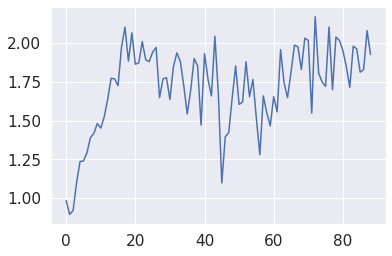

In [ ]:
# plot the losslog
import matplotlib.pyplot as plt
plt.plot(test_loss_log)

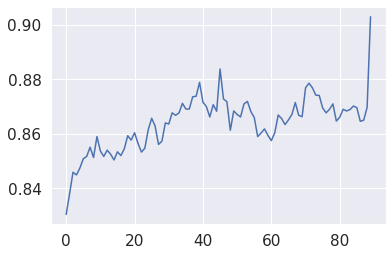

In [ ]:
# plot the accuracy log
import matplotlib.pyplot as plt
plt.plot(test_acc_log[0:90])

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
pred = model_cnn(x_test)
pred = np.argmax(pred, axis=1)

y_test_c = np.argmax(y_test, axis=1)
y_test_c

# compute de confusion matrix
conf_mat = confusion_matrix(y_test_c, pred)

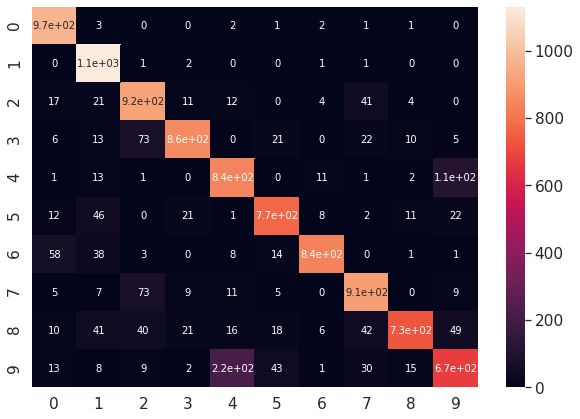

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf_mat, range(10), range(10))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size

# plotting the confusion matrix
plt.show()